# Generative Adversarial Network for ECG synthesis
This notebook is an addition to this [notebook](https://www.kaggle.com/polomarco/ecg-classification-cnn-lstm-attention-mechanism).

C:\Users\jespe\AppData\Local\Temp\ipykernel_15692\574050403.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(io.imread("https://i.pinimg.com/originals/97/c8/0e/97c80e536a8b8712a8299dddb9f14e07.jpg"))


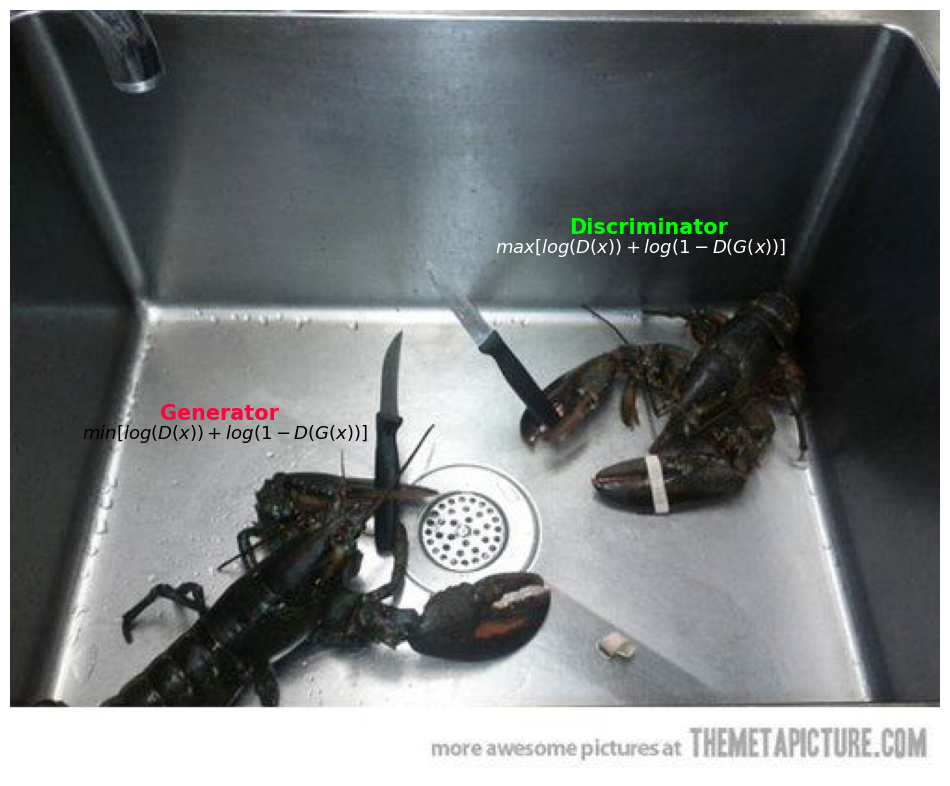

In [1]:
import matplotlib.pyplot as plt
import cv2
import imageio as io

lat_D = 'max[log(D(x))+log(1-D(G(x))]'
lat_G = 'min[log(D(x))+log(1-D(G(x))]'

plt.figure(figsize=(12, 10))
plt.imshow(io.imread("https://i.pinimg.com/originals/97/c8/0e/97c80e536a8b8712a8299dddb9f14e07.jpg"))
plt.axis('off');

plt.text(80, 220, "Generator", 
         fontdict={
             "fontsize":15,
             "color":"#FF033E",
             "weight": "bold"
             }
         );
plt.text(38, 230, r"$%s$" % lat_G, 
         fontdict={
             "fontsize":13,
             "color":"black",
             "weight": "bold"
             }
         );
                                                                                               
plt.text(300, 120, r"Discriminator", 
         fontdict={
             "fontsize":15,
             "color":"lime",
             "weight": "bold"
             }
         );
         
plt.text(260, 130, r"$%s$" % lat_D,
         fontdict=
         {"fontsize":13,
          "color":"white",
          "weight": "bold"
          }
         );

![](https://64.media.tumblr.com/66dc00e688f72af4d7b5d768005359c4/094fefb7e60b17ee-9c/s500x750/3060385c5fdcb38f3a716d8a309a40e69e598a5f.png)

In [2]:
import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam


In [3]:
# Def to combine all CSV files in a directory into a single DataFrame
def combine_csv_files_to_df(dir_path):
    # Get all CSV files in the directory
    csv_files = [file for file in os.listdir(dir_path) if file.endswith('.csv')]

    df_list = [pd.read_csv(os.path.join(dir_path, file), header=None) for file in csv_files]
    combined_data = pd.concat(df_list, ignore_index=True,)

    # Display the combined DataFrame
    return(combined_data)


In [4]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = Config()
seed_everything(config.seed)

In [5]:
# df_ptbdb = pd.read_csv('/kaggle/input/heartbeat/ptbdb_abnormal.csv')
df_mitbih = combine_csv_files_to_df('./Dataset_mitbih/Training/')
df_mitbih.head()

0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  

[5 rows x 188 columns]

In [6]:
df_mitbih_train = combine_csv_files_to_df('./Dataset_mitbih/Training/')
df_mitbih_test = combine_csv_files_to_df('./Dataset_mitbih/Testing/')
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
print(df_mitbih.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 158.7+ MB
None


In [7]:
df_mitbih.to_csv('data.csv', index=False)
config.csv_path = 'data.csv'

# Basic EDA

In [8]:
df_mitbih['label'].value_counts()

Normal                               90589
Fusion of paced and normal            8039
Premature ventricular contraction     7236
Artial Premature                      2779
Fusion of ventricular and normal       803
Name: label, dtype: int64

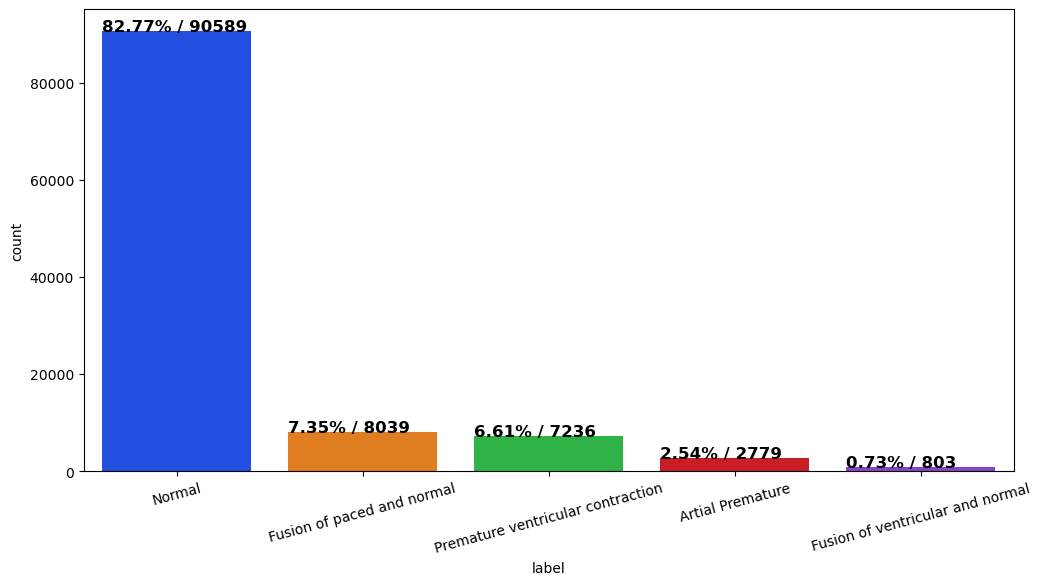

In [9]:
percentages = [count / df_mitbih.shape[0] * 100 for count in df_mitbih['label'].value_counts()]

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=df_mitbih['label'],
    ax=ax,
    palette="bright",
    order=df_mitbih['label'].value_counts().index
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15);

for percentage, count, p in zip(
    percentages,
    df_mitbih['label'].value_counts(sort=True).values,
    ax.patches):
    
    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage)+" / "+str(count), (x, y), fontsize=12, fontweight='bold')
    
plt.savefig('data_dist.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('data_dist.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

# Dataset

In [10]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])                 
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

def get_dataloader(label_name, batch_size):
    df = pd.read_csv(config.csv_path)
    df = df.loc[df['label'] == label_name]
    df.reset_index(drop=True, inplace=True)
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
    return dataloader
    
    
dataloader = get_dataloader(label_name='Artial Premature', batch_size=96)

print(len(dataloader))
x,y = next(iter(dataloader))
x.shape, y.shape

29


C:\Users\jespe\AppData\Local\Temp\ipykernel_15692\3944258185.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  signal = torch.FloatTensor([signal.values])


(torch.Size([96, 1, 187]), torch.Size([96]))

# Models

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 187)
        self.rnn_layer = nn.LSTM(
                input_size=187,
                hidden_size=128,
                num_layers=1,
                bidirectional=True,
                batch_first=True,
            )
    def forward(self, x):
        x,_ = self.rnn_layer(x)
        x = x.view(-1,256)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = self.fc3(x)
        return x.unsqueeze(1)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.rnn_layer = nn.LSTM(
                input_size=187,
                hidden_size=256,
                num_layers=1,
                bidirectional=True,
                batch_first=True,
            )
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x,_ = self.rnn_layer(x)
        x = x.view(-1, 512)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = torch.sigmoid(self.fc3(x))
        return x

# Training stage

In [12]:
class Trainer:
    def __init__(
        self,
        generator,
        discriminator,
        batch_size,
        num_epochs,
        label
    ):
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.netG = generator.to(self.device)
        self.netD = discriminator.to(self.device)
        
        self.optimizerD = Adam(self.netD.parameters(), lr=0.0002)
        self.optimizerG = Adam(self.netG.parameters(), lr=0.0002)
        self.criterion = nn.BCELoss()
        
        self.batch_size = batch_size
        self.signal_dim = [self.batch_size, 1, 187]
        self.num_epochs = num_epochs
        self.dataloader = get_dataloader(
            label_name=label, batch_size=self.batch_size
        )
        self.fixed_noise = torch.randn(self.batch_size, 1, 187,
                                       device=self.device)
        self.g_errors = []
        self.d_errors = []
        
    def _one_epoch(self):
        real_label = 1
        fake_label = 0
        
        for i, data in enumerate(self.dataloader, 0):
            ##### Update Discriminator: maximize log(D(x)) + log(1 - D(G(z))) #####
            ## train with real data
            self.netD.zero_grad()
            real_data = data[0].to(self.device)
            # dim for noise
            batch_size = real_data.size(0)
            self.signal_dim[0] = batch_size
            
            label = torch.full((batch_size,), real_label,
                           dtype=real_data.dtype, device=self.device)
            
            output = self.netD(real_data)
            output = output.view(-1)
       
            errD_real = self.criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()
            
            ## train with fake data
            noise = torch.randn(self.signal_dim, device=self.device)
            fake = self.netG(noise)
            label.fill_(fake_label)
            
            output = self.netD(fake.detach())
            output = output.view(-1)
            
            errD_fake = self.criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake 
            self.optimizerD.step()
            
            ##### Update Generator: maximaze log(D(G(z)))  
            self.netG.zero_grad()
            label.fill_(real_label) 
            output = self.netD(fake)
            output = output.view(-1)
            
            errG = self.criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            self.optimizerG.step()
            
        return errD.item(), errG.item()
        
    def run(self):
        for epoch in range(self.num_epochs):
            errD_, errG_ = self._one_epoch()
            self.d_errors.append(errD_)
            self.g_errors.append(errG_)
            if epoch % 300 == 0:
                print(f"Epoch: {epoch} | Loss_D: {errD_} | Loss_G: {errG_} | Time: {time.strftime('%H:%M:%S')}")
   
                fake = self.netG(self.fixed_noise)
                plt.plot(fake.detach().cpu().squeeze(1).numpy()[:].transpose())
                plt.show()
            
        torch.save(self.netG.state_dict(), f"generator.pth")
        torch.save(self.netG.state_dict(), f"discriminator.pth")

In [13]:
g = Generator()
d = Discriminator()

Epoch: 0 | Loss_D: 1.047755241394043 | Loss_G: 0.6805279850959778 | Time: 15:59:46


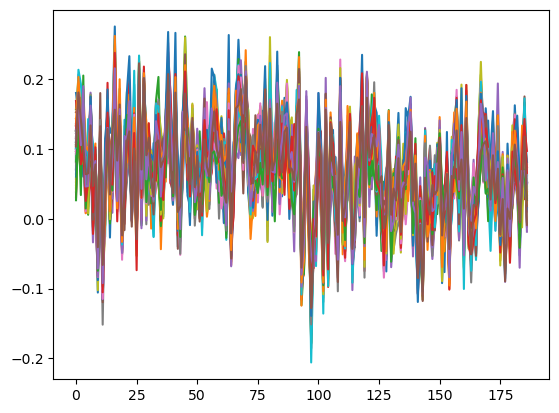

Epoch: 300 | Loss_D: 0.9252827167510986 | Loss_G: 1.6189320087432861 | Time: 16:14:42


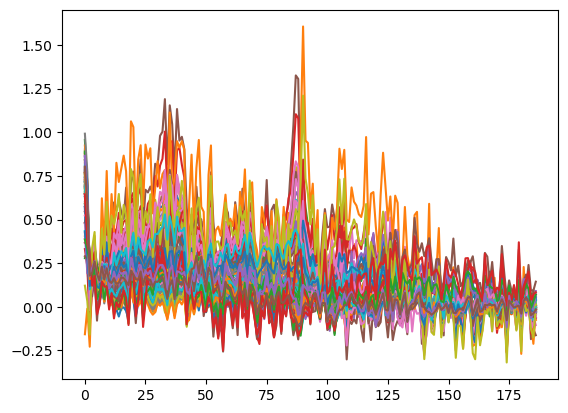

Epoch: 600 | Loss_D: 0.8576986193656921 | Loss_G: 1.3454068899154663 | Time: 16:29:27


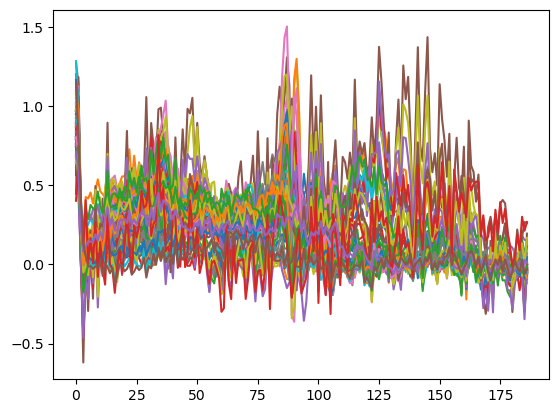

Epoch: 900 | Loss_D: 0.6875499486923218 | Loss_G: 1.7929011583328247 | Time: 16:44:14


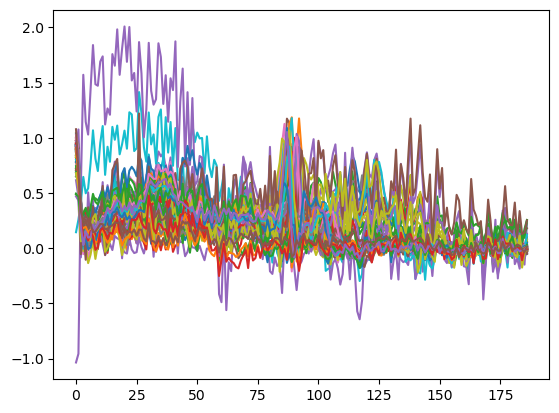

Epoch: 1200 | Loss_D: 0.7768546342849731 | Loss_G: 1.8133519887924194 | Time: 16:59:02


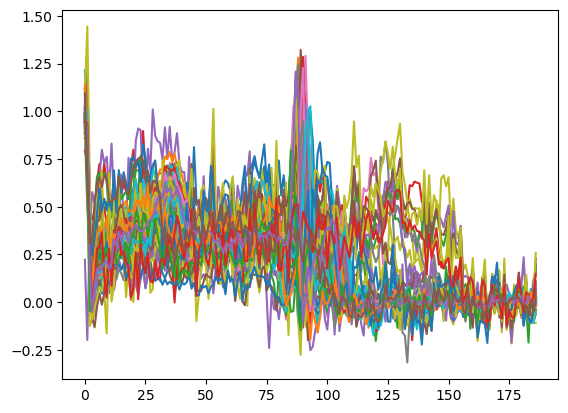

Epoch: 1500 | Loss_D: 0.6305369138717651 | Loss_G: 2.5234615802764893 | Time: 17:13:49


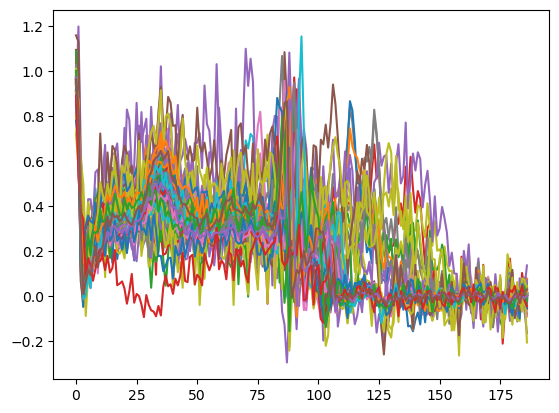

Epoch: 1800 | Loss_D: 0.43334442377090454 | Loss_G: 2.1146671772003174 | Time: 17:29:10


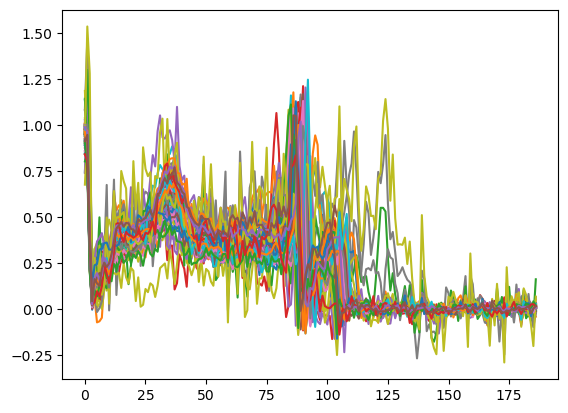

Epoch: 2100 | Loss_D: 0.571006715297699 | Loss_G: 1.9347909688949585 | Time: 17:44:19


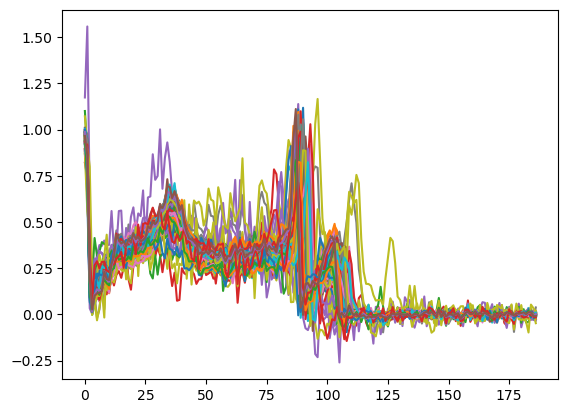

Epoch: 2400 | Loss_D: 0.33258113265037537 | Loss_G: 1.7664103507995605 | Time: 17:59:22


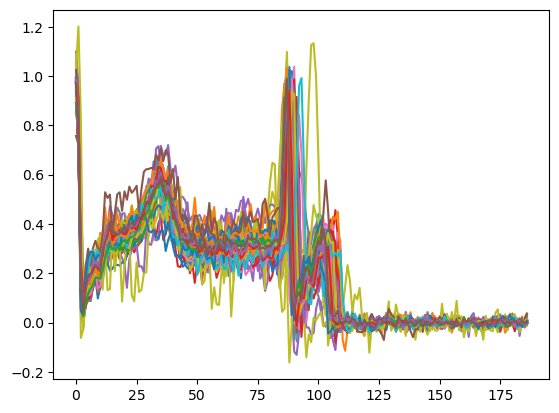

Epoch: 2700 | Loss_D: 0.38629093766212463 | Loss_G: 2.056467294692993 | Time: 18:14:23


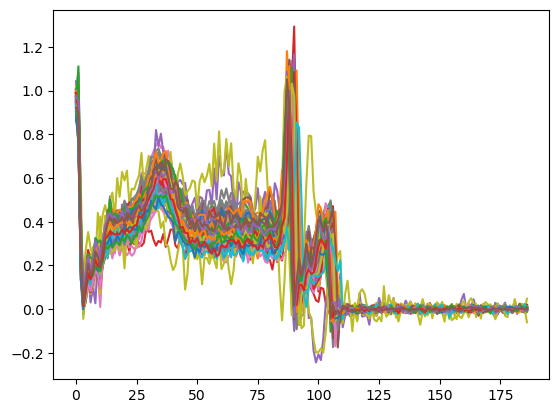

In [14]:
trainer = Trainer(
    generator=g,
    discriminator=d,
    batch_size=96,
    num_epochs=3000,
    label='Artial Premature'
)
trainer.run()

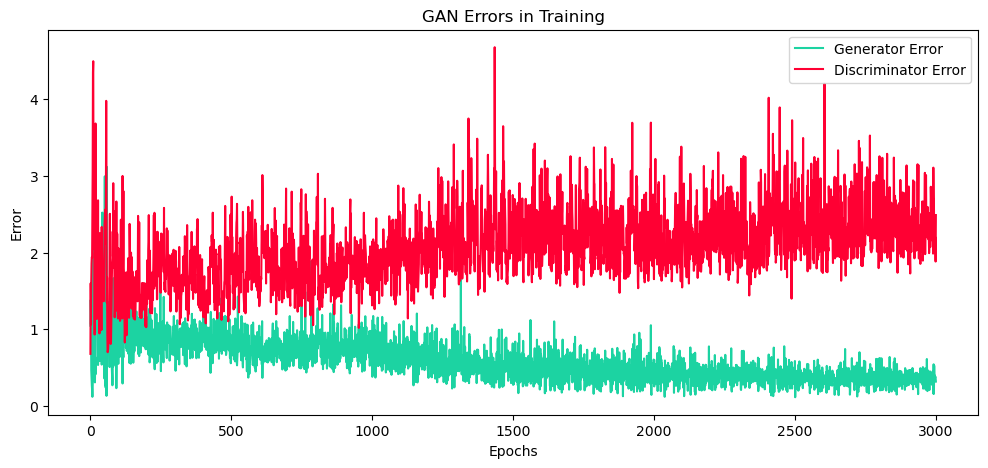

In [15]:
plt.figure(figsize=(12, 5))
plt.title("GAN Errors in Training")
plt.plot(trainer.d_errors, label='Generator Error', c='#1CD3A2')
plt.plot(trainer.g_errors, label='Discriminator Error', c='#FF0033')
plt.xlabel("Epochs")
plt.ylabel('Error')
_ = plt.legend()
plt.savefig('Gan_Losses.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('Gan_Losses.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

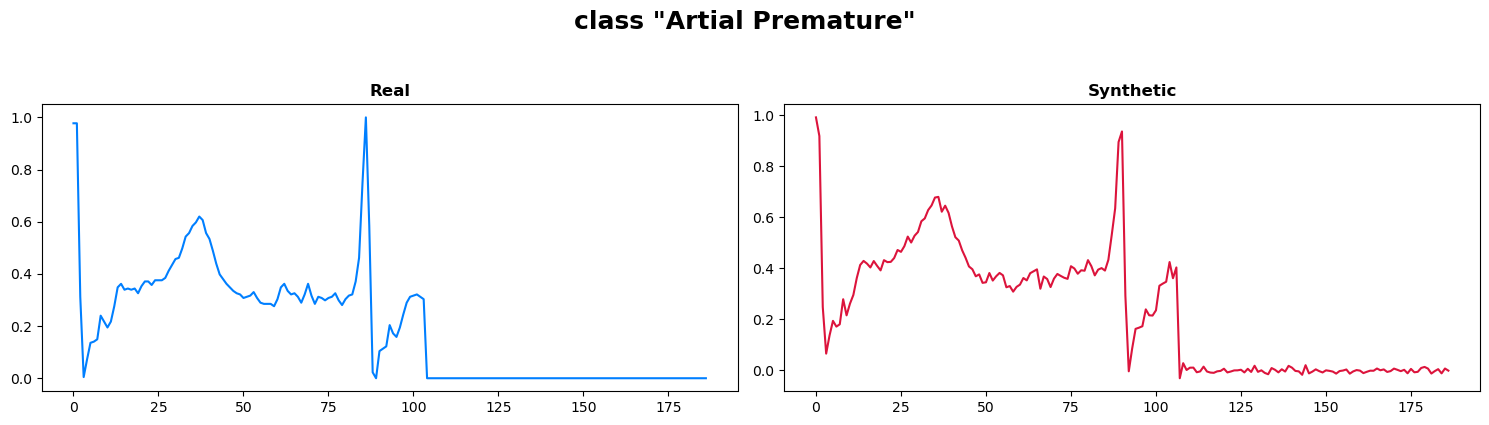

In [55]:
df = pd.read_csv(config.csv_path)
df = df.loc[df['label'] == 'Artial Premature']

# real signal
N = 1
real_samples =  df.sample(N).values[:, :-2].transpose()

#synthetic signal
fake = trainer.netG(trainer.fixed_noise)
index = np.random.choice(fake.shape[0], N, replace=False) 
synthetic_samples = fake.detach().cpu().squeeze(1).numpy()[index].transpose()

fig, axs = plt.subplots(1, 2, figsize=(15, 4))


axs[0].plot(real_samples, c='#007FFF')
axs[0].set_title("Real", fontsize= 12, weight="bold")


axs[1].plot(synthetic_samples, c="crimson")
axs[1].set_title("Synthetic", fontsize= 12, weight="bold")

plt.suptitle('class "Artial Premature"', fontsize=18, y=1.05, weight="bold")
plt.tight_layout()
plt.savefig('Artial Premature.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig('Artial Premature.svg', facecolor='w', edgecolor='w', format='svg',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

In [ ]:
# Save the GAN


In [59]:
import pandas as pd
import numpy as np

# assume you have a trained generator function called "generate_sample"
# that takes a noise vector as input and returns a generated sample
# set the number of samples to generate
num_samples = 8000

# set the dimensionality of the noise vector to match the generator input
noise_dim = 100

# create an empty list to hold the generated samples
samples = []

# convert the list of samples to a pandas DataFrame
df = pd.DataFrame()

# generate X samples using the generator
for i in range(num_samples):
    # generate random noise vector
    noise = np.random.normal(0, 1, noise_dim)
    # generate a sample using the generator
    fake = trainer.netG(trainer.fixed_noise)
    index = np.random.choice(fake.shape[0], N, replace=False) 
    synthetic_samples = fake.detach().cpu().squeeze(1).numpy()[index].transpose()
    # Reshape the sample to be 1D
    synthetic_samples = synthetic_samples.reshape(1, -1)

    # add synthetic sample to the df as a row
    df = df.append(pd.DataFrame(synthetic_samples))


# save the DataFrame to a CSV file
df.to_csv('generated_samples.csv', index=False)

C:\Users\jespe\AppData\Local\Temp\ipykernel_15692\1958198357.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(synthetic_samples))
C:\Users\jespe\AppData\Local\Temp\ipykernel_15692\1958198357.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(synthetic_samples))
C:\Users\jespe\AppData\Local\Temp\ipykernel_15692\1958198357.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(synthetic_samples))
C:\Users\jespe\AppData\Local\Temp\ipykernel_15692\1958198357.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(synthetic_sample

In [30]:
# # get the values in the range of 0 to 1
# df_norm = (df - df.min()) / (df.max() - df.min())

# # limit the range of the values between 0 and 1
# df_norm = df_norm * (1 - 0) + 0
# df_norm
# # save the DataFrame to a CSV file
# df_norm.to_csv('generated_samples1.csv', index=False)

In [38]:
# def plot_ecg_examples(df, label, n_examples=5):    
#     filtered_df = df[df[187] == label]

#     # choose 5 random instances from the filtered DataFrame
#     random_instances = filtered_df.sample(n=n_examples, random_state=42)

#     return random_instances
# # Add column named 187 with only the value 1
# df_norm[187] = 1


# samples = list()
# samples.append(plot_ecg_examples(df_norm, 1, 5))

In [40]:
# fig, axs = plt.subplots(3, 2, figsize=(10, 8))
# # titles = labels
# for i in range(1):
#     ax = axs.flat[i]
#     ax.plot(samples[i].values[:,:-2].transpose())
#     # ax.set_title(titles[i])

# fig.tight_layout()
# plt.show()

In [60]:
# load the DataFrame from the CSV file
df_generated = pd.read_csv('generated_samples.csv')

In [61]:
df_generated[187] = 1
df_generated

0         1         2         3         4         5         6  \
0     0.915009  0.835311  0.178229 -0.010374  0.083616  0.131879  0.112279   
1     0.984370  0.900088  0.230375  0.021089  0.052217  0.126854  0.093552   
2     0.972488  0.876487  0.237004  0.014626  0.045844  0.091558  0.104766   
3     0.922158  0.798313  0.142464  0.003448  0.072673  0.121930  0.105940   
4     1.043076  0.978682  0.309280  0.069887  0.239820  0.263684  0.243263   
...        ...       ...       ...       ...       ...       ...       ...   
7995  0.969356  1.101294  0.370745  0.091415  0.138155  0.240818  0.231619   
7996  0.972352  0.847217  0.212078  0.015675  0.113756  0.148514  0.138418   
7997  0.992469  0.966112  0.241151  0.036005  0.128173  0.175430  0.153649   
7998  0.976325  0.983133  0.495235  0.279048  0.315849  0.378001  0.415146   
7999  0.993813  0.855875  0.208637  0.064316  0.163322  0.176418  0.157648   

             7         8         9  ...       178       179       180  \
0     0.151765  0.200770  0.191635  ...  0.011104  0.006141  0.000081   
1     0.135447  0.200918  0.165995  ... -0.000308  0.012638  0.007678   
2     0.123837  0.154608  0.160589  ...  0.005679  0.007317  0.008362   
3     0.149545  0.182272  0.166507  ...  0.013367  0.007472  0.004198   
4     0.260813  0.291859  0.296907  ... -0.013334 -0.001745  0.001852   
...        ...       ...       ...  ...       ...       ...       ...   
7995  0.226629  0.318113  0.300770  ... -0.006124  0.007470  0.003579   
7996  0.223164  0.230143  0.208189  ...  0.003932  0.005463  0.004767   
7997  0.141733  0.254529  0.213155  ... -0.003158  0.006838  0.001957   
7998  0.439624  0.391488  0.404690  ...  0.019140  0.004504  0.009234   
7999  0.278289  0.262799  0.210103  ... -0.000741  0.003817  0.009790   

           181       182       183       184       185       186  187  
0     0.003620 -0.003944 -0.007017  0.004015  0.012689  0.015563    1  
1    -0.009802  0.006253 -0.001771 -0.005892  0.001900 -0.001575    1  
2    -0.007414 -0.000442 -0.002197 -0.003717  0.002979  0.002643    1  
3    -0.015825  0.002066 -0.004081 -0.006395  0.011079  0.014992    1  
4     0.009766  0.000605 -0.009912  0.002686  0.003891 -0.012270    1  
...        ...       ...       ...       ...       ...       ...  ...  
7995 -0.004650 -0.003296  0.005676 -0.014070  0.005561 -0.001636    1  
7996 -0.002208  0.002980 -0.003553 -0.001607 -0.001156  0.001880    1  
7997 -0.012689  0.001496 -0.001571 -0.019347  0.003470 -0.001129    1  
7998  0.026155 -0.016957  0.002976 -0.015325  0.010003 -0.006836    1  
7999 -0.006334  0.011573 -0.003871 -0.010543 -0.000809 -0.001828    1  

[8000 rows x 188 columns]

In [62]:
df_generated.to_csv('generated_samples.csv', index=False)

# Load in GAN

In [56]:
generator_state_dict = torch.load('generator.pth')
generator1 = Generator()
generator1.load_state_dict(generator_state_dict)




<All keys matched successfully>

In [58]:
# assume you have a trained generator function called "generate_sample"
# that takes a noise vector as input and returns a generated sample
# set the number of samples to generate
num_samples = 40

# set the dimensionality of the noise vector to match the generator input
noise_dim = 100

# create an empty list to hold the generated samples
samples = []

# convert the list of samples to a pandas DataFrame
df_asdf = pd.DataFrame()

for i in range(num_samples):
    # generate random noise vector
    noise = np.random.normal(0, 1, noise_dim)
    # generate a sample using the generator
    fake = generator1(trainer.fixed_noise)
    index = np.random.choice(fake.shape[0], N, replace=False) 
    synthetic_samples = fake.detach().cpu().squeeze(1).numpy()[index].transpose()
    # Reshape the sample to be 1D
    synthetic_samples = synthetic_samples.reshape(1, -1)

    # add synthetic sample to the df as a row
    df_asdf = df_asdf.append(pd.DataFrame(synthetic_samples))

# save the DataFrame to a CSV file
df_asdf.to_csv('generated_samples_test.csv', index=False)

C:\Users\jespe\AppData\Local\Temp\ipykernel_15692\2090726766.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_asdf = df_asdf.append(pd.DataFrame(synthetic_samples))
C:\Users\jespe\AppData\Local\Temp\ipykernel_15692\2090726766.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_asdf = df_asdf.append(pd.DataFrame(synthetic_samples))
C:\Users\jespe\AppData\Local\Temp\ipykernel_15692\2090726766.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_asdf = df_asdf.append(pd.DataFrame(synthetic_samples))
C:\Users\jespe\AppData\Local\Temp\ipykernel_15692\2090726766.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_asdf = df_a

# Conclusion
Since this is a standard process for training a GAN model, we can observe that the Generator produces predominantly dominant signal types.
More specifically, we have a total of 803 signals of the '"Fusion of ventricular and normal"' class, most of which are very similar, and that's what GAN model learned to generate.